In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,array_to_img
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.models import load_model

Load model and Helper functions

In [ ]:
  
model=load_model('/content/gdrive/My Drive/models/sp_model_15_softmax2.h5')#trained model

#function to preprocess image   
def preprocess_img(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = image[None, ...]
    
    return image

#for reverse pre-process
def restore_original_image_from_array(x, data_format='channels_last'):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x



def reverse_preprocess(p_img,a_numpy=True):
    if a_numpy:
      p_img=p_img.numpy()
    ip_img=restore_original_image_from_array(p_img, data_format='channels_last')
    ia_img=array_to_img(ip_img[0])
    img=ia_img
    return img

#helper function to display images
def l_display_images(model,image,description,savepath=None,save=False,single_img=True,categorical=True):

    classes={0:'Unaffected',1:'DR Affected'}
    i=0
    if (single_img==False):
      for img in image:
        preds=model.predict(img)
        if categorical:
            label=np.argmax(preds)
            class_confidence=preds[i][label]
        else:
            label = (preds > 0.5).reshape(1).astype(np.int)[0]
            class_confidence=preds.reshape(1).astype(np.float32)[0]
        
        print(label)
        image_class=classes[label]
      
        print("result",label,image_class, class_confidence)

        img=reverse_preprocess(img)
        plt.figure()
        plt.imshow(img)
        plt.title('{} \n {} : {:.2f}%'.format(description,
                                                        image_class,class_confidence*100))
        plt.show()
        if save:
          path=savepath+'img{}'.format(i)
          save_img(path)
        i=i+1
        print('completed')
    else:

      preds=model.predict(image)
      if categorical:
          label=np.argmax(preds)
          class_confidence=preds[0][label]
      else:
          label = (preds > 0.5).reshape(1).astype(np.int)[0]
          class_confidence=preds.reshape(1).astype(np.float32)[0]
        
      print(label)
      image_class=classes[label]
      print("result",preds,image_class, class_confidence)

      img=reverse_preprocess(image)
      plt.figure()
      plt.imshow(img)
      plt.title('{} \n {} : {:.2f}%'.format(description,
                                                      image_class,class_confidence*100))
      plt.show()
      if save:
        path=savepath+'img{}'.format(i)
        save_img(path)



Test data

In [ ]:
with np.load('/content/gdrive/My Drive/models/sp_test_conf.npz') as data:
    dataset = data["dataset"]
    labels = data["labels"]
    conf=data['conf']

In [ ]:
x=[]
y=[]
confidence=[]
i=0
c=0
preds=model(dataset)
for i in range(100):
     #print(i)
     label=np.argmax(preds[i])
     class_confidence=preds[i][label]
     conf=class_confidence*100
     if (label!=labels[i]):
        c=c+1
        continue 
     x.append(dataset[i])
     confidence.append(conf) 
     y.append(labels[i])

In [ ]:
x=np.asarray(x)
y=np.asarray(y)
confidence=np.asarray(confidence)
print(x.shape,y.shape,confidence.shape)

(100, 224, 224, 3) (100,) (100,)


In [ ]:
np.savez('/content/gdrive/My Drive/models/sp_test_conf.npz',dataset=x,labels=y,conf=confidence)

Target lables

In [ ]:

t_labels=np.zeros(y.shape)
for i in range(100):
    t=1-y[i]
    t_labels[i]=t

Preprocessed images

In [ ]:
p_img=np.zeros(x.shape)
for i in range(100):
  p_img[i]=preprocess_img(x[i])

#p_img=tf.convert_to_tensor(p_img)
p_img=tf.cast(p_img,dtype=tf.float32)
print(p_img.dtype)

<dtype: 'float32'>


to display single image(for testing)
load an image to test

(1, 224, 224, 3)
0
result [[0.7324375  0.26756254]] Unaffected 0.7324375


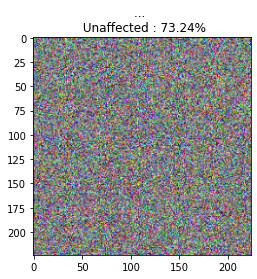

(1, 2)
()


In [ ]:

#loss function to use for distillation
def fn(correct, predicted,train_temp=100): 
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                    logits=predicted/train_temp)
    

img = load_img('noise_1.png', color_mode="rgb")
a_img = img_to_array(img)

random_img=np.random.randint(255,size=a_img.shape,dtype=np.int32)
p_img = preprocess_img(random_img)
print(p_img.shape)

#display_images(model,img,"Original")
l_display_images(model,p_img,"...",savepath="",save=False,single_img=True)
print((model(p_img).shape))
preds=model(p_img)
label=np.argmax(preds)
print(label.shape)




In [ ]:

batch_shape=p_img[:1].shape #shape of the image inputs 
max_epsilon =50  # Max epsilon on the original range (0 to 255)
max_iter = 30 # Maximun number of iterations

eps = 2.0 * max_epsilon / 255.0 # Max epsilon on the range of the processed images (-1 to 1)

"""t_lable=np.array([[1,0]])
loss_fn=tf.keras.losses.CategoricalCrossentropy()
"""

t_lable=np.array([[0]])
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()
lbfgs_attacker = box_constrained_attack_with_norm(model,batch_shape, max_epsilon=eps, max_iter=max_iter,targeted=True,input=attack_img,output=t_lable)   


attack_img,norm,conf,f_label = lbfgs_attacker.generate(p_img,t_lable,verbose=True)


1
result [[0.4958734  0.50412667]] DR Affected 0.50412667


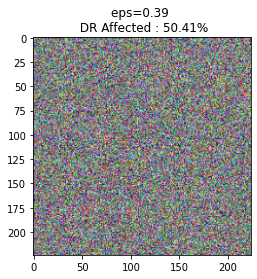

tf.Tensor([17050.986], shape=(1,), dtype=float32)


In [ ]:
l_display_images(model,attack_img,"eps=0.39")
print(norm)

Running in loop(applies the attack on 100 images together)

In [ ]:

batch_shape=p_img[:1].shape #shape of the image inputs 
max_epsilon =25  # Max epsilon on the original range (0 to 255)
max_iter = 30 # Maximun number of iterations

eps = 2.0 * max_epsilon / 255.0 # Max epsilon on the range of the processed images (-1 to 1)
#eps=0.3

t_lable=t_labels #target label
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()

lbfgs_attacker = box_constrained_attack_with_norm(model,batch_shape, max_epsilon=eps, max_iter=max_iter,targeted=True,input=p_img[:1],output=t_labels[:1])   

attack_imgs=[]
norms=[]
confs=[]
f_labels=[]
for i in range(100):
  attack_img,norm,conf,f_label = lbfgs_attacker.generate(p_img[i:i+1],t_labels[i:i+1],verbose=True)
  attack_imgs.append(attack_img)
  if (f_label!=-1):
    norms.append(norm)
    confs.append(conf)
  f_labels.append(f_label)
#display_images(model,attack_img,"L-BFGS")
#print(model(attack_img))
#plt.imshow(attack_img[0])
#plt.show() 

Number of successful adv created
-1 is returned for failures

In [ ]:
print(len(confs))
c=0
ind=[]
for i in range(100):
  if (f_labels[i]!=-1):
    c=c+1
    ind.append(i)
print(c)

90
90


Number of sucessesful adversaries,with more confidence in misclassification

In [ ]:
d=0
j=0
for i in range(len(ind)):
  if (confs[j]>confidence[ind[i]]):
    d=d+1
  j=j+1
print(d)

71


Computing norm and confidence

In [ ]:
conf_avg=np.average(confs)
conf_max=np.max(confs)
norm_avg=np.average(norms)
norm_max=np.max(norms)
print(conf_avg,conf_max,norm_avg,norm_max)

76.70886 96.290016 5001.492 5650.791


In [ ]:
print(c)
#np.linalg.norm([attack_img,img])
def l2(x, y):
    # technically squarred l2
    return tf.reduce_sum(tf.square(x - y), list(range(1, len(x.shape))))

l2(attack_img,img)

0.15


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([11210.863], dtype=float32)>

L-BFGS without norm, optimizes just over the loss. 
Epsilon value has no big effect.Gave identical results for diff eps values.

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import tensorflow as tf
#from scipy.misc import imread, imsave


class box_constrained_attack:
    """ Creates adversarial samples using box contrained L-BFGS
    """

    def __init__(self,
                 model,
                 batch_shape,
                 max_epsilon,
                 max_iter,
                 targeted,
                 input,
                 output=None,
                 loss_fn=None,
                 img_bounds=(-1, 1),
                 use_noise=True,
                 max_ls=5,
                 n_classes=2,
                 rng=np.random.RandomState()):
        """ 
             model: Callable (function) that accepts an input tensor 
                    and return the model logits (unormalized log probs)
             batch_shape: Input shapes (tuple). 
                    Usually: [batch_size, height, width, channels]
             max_epsilon: Maximum L_inf norm for the adversarial example
             max_iter: Maximum number of iterations (gradient computations)
             targeted: Boolean: true for targeted attacks, false for non-targeted attacks
             img_bounds: Tuple [min, max]: bounds of the image. Example: [0, 255] for
                    a non-normalized image, [-1, 1] for inception models.
             max_ls: Maximum number of line searches
             rng: Random number generator 
        """

        self.x_input =input
        if output is None:
          self.y_input = np.argmax(model(input)).reshape(batch_shape[0],1)
        else:
          self.y_input=output
        # Loss function: the mean of the logits of the correct class
        #y_onehot = tf.one_hot(self.y_input, n_classes)
      
        #logits_correct_class = tf.reduce_sum(logits * y_onehot, axis=1)
        if loss_fn is None:
            self.loss_fn= tf.keras.losses.SparseCategoricalCrossentropy()
        else:
          self.loss_fn=loss_fn

        with tf.GradientTape() as gt:
          gt.watch(self.x_input)
          lables = model(self.x_input)
          self.loss=self.loss_fn(self.y_input,lables)
          
        self.grad = gt.gradient(self.loss, self.x_input)

        self.targeted = targeted
        self.max_iter = max_iter
        self.max_epsilon = max_epsilon
        self.batch_shape = batch_shape
        self.img_bounds = img_bounds
        self.use_noise = use_noise
        self.rng = rng
        self.max_ls = max_ls

    def generate(self,images,t_lables,verbose=False):
        """ Generates adversarial images/
            images: a 4D tensor containing the original images
            labels_or_targets: for non-targeted attacks, the actual or predicted labels
                               for targeted attacks, the desired target classes for each image.
            c
            returns: adv_images: a 4D tensor containing adversarial images
        """
        lower_bounds = np.minimum(-1 - images, -self.max_epsilon).reshape(-1)
        upper_bounds = np.maximum(1 - images, self.max_epsilon).reshape(-1)
  

        bounds = list(zip(lower_bounds, upper_bounds))
        if self.targeted:
          t_label=t_lables
        else:
          t_label=np.argmax(model(images)).reshape(self.batch_shape[0],1)
          print(t_label)

        if self.use_noise:
            alpha = self.max_epsilon * 0.5
            x0 = alpha * np.sign(np.random.random(np.prod(images.shape)))
        else:
            x0 = np.zeros(np.prod(images.shape))

        if verbose:
            iprint = 1
        else:
            iprint = -1
      
        #function to compute gradient of loss
        def func(delta): 
          attack_img = images + delta.reshape(images.shape).astype(np.float64)
          loss_fn= self.loss_fn

          with tf.GradientTape() as gt:
            gt.watch(attack_img)
            label=model(attack_img)
            loss=loss_fn(t_label,label)

          #print(label,t_label)
          grad=gt.gradient(loss,attack_img)
          grad=tf.reshape(grad,-1)

          norm=l2(attack_img,images)
          #print("norm",norm)

          loss= loss.numpy().astype(np.float64)
          grad=grad.numpy().astype(np.float64)

          #loss=loss+norm
          #print("loss",loss)
          if self.targeted:
              # Multiply by -1 since we want to maximize it.
              return  loss,grad
          else: 
              return -1*loss,-1*grad
    
        delta_best, f, d = fmin_l_bfgs_b(func=func,
                                        x0=x0,
                                        bounds=bounds,
                                        maxfun=self.max_iter,
                                        maxls=self.max_ls)
        
        adv_img=images+delta_best.reshape(images.shape).astype(np.float64)
        norm=l2(adv_img,images)
        
        preds=model.predict(adv_img)
        lables=np.argmax(preds,axis=1)
        print(preds,lables)
        
        confidence=np.max(preds,axis=1)*100
        print(confidence)
        
        return images + delta_best.reshape(images.shape).astype(np.float64),norm,confidence,lables
  

Helper functions to display

In [ ]:
def display_images(model,image, description):
  preds=model.predict(image)
  _, image_class, class_confidence = get_label(preds)
  print("res",np.argmax(preds),image_class, class_confidence)
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   image_class, class_confidence*100))
  plt.show()




L-BFGS with norm condition added.

I added the norm condition and binary searching 'c' parameter by refering sources

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import tensorflow as tf
#from scipy.misc import imread, imsave


class box_constrained_attack_with_norm:
    """ Creates adversarial samples using box contrained L-BFGS
    """

    def __init__(self,
                 model,
                 batch_shape,
                 max_epsilon,
                 max_iter,
                 targeted,
                 input,
                 output=None,
                 loss_fn=None,
                 img_bounds=(-1, 1),
                 use_noise=True,
                 max_ls=5,
                 n_classes=1001,
                 rng=np.random.RandomState()):
        """ 
             model: Callable (function) that accepts an input tensor 
                    and return the model logits (unormalized log probs)
             batch_shape: Input shapes (tuple). 
                    Usually: [batch_size, height, width, channels]
             max_epsilon: Maximum L_inf norm for the adversarial example
             max_iter: Maximum number of iterations (gradient computations)
             targeted: Boolean: true for targeted attacks, false for non-targeted attacks
             img_bounds: Tuple [min, max]: bounds of the image. Example: [0, 255] for
                    a non-normalized image, [-1, 1] for inception models.
             max_ls: Maximum number of line searches
             rng: Random number generator 
        """

        self.x_input =input

        if output is None:
          self.y_input = np.argmax(model(input)).reshape(batch_shape[0],1) #untargeted, uses the predicted lable 
        else:
          self.y_input=output #targeted, target lable
      
        if loss_fn is None:
           self.loss_fn= tf.keras.losses.SparseCategoricalCrossentropy()
        else:
           self.loss_fn=loss_fn

        #computing initial gradient of loss wrt to inputs
        with tf.GradientTape() as gt:
          gt.watch(self.x_input) 
          lables = model(self.x_input)
          self.loss=self.loss_fn(self.y_input,lables)
          
        self.grad = gt.gradient(self.loss, self.x_input)

        self.targeted = targeted
        self.max_iter = max_iter
        self.max_epsilon = max_epsilon
        self.batch_shape = batch_shape
        self.img_bounds = img_bounds
        self.use_noise = use_noise
        self.rng = rng
        self.max_ls = max_ls
        self.adversary=input
        self.model=model
    

    def l2(x, y):
        # technically squarred l2
        return tf.reduce_sum(tf.square(x - y), list(range(1, len(x.shape))))
           
    #function to generate adversaries
    def generate(self,images,t_labels,verbose=False):
        """ Generates adversarial images/
            images: a 4D tensor containing the original images
            t_labels: for non-targeted attacks, the actual or predicted labels
                               for targeted attacks, the desired target classes for each image.
            
            returns: adv_images: a 4D tensor containing adversarial images
        """

        #lower and upper bounds to clip the image(eps value is used here)
        lower_bounds = np.minimum(-1 - images, -self.max_epsilon).reshape(-1)
        upper_bounds = np.maximum(1 - images, self.max_epsilon).reshape(-1)
        bounds = list(zip(lower_bounds, upper_bounds))
     
       #to use random starting point
        if self.use_noise:
            alpha = self.max_epsilon * 0.5
            x0 = alpha * np.sign(np.random.random(np.prod(images.shape)))
        else:
            x0 = np.zeros(np.prod(images.shape))

        if verbose:
            iprint = 1
        else:
            iprint = -1
        
        #targeted case, use given target lables
        if self.targeted:
              self.t_label=t_labels
        else:
              self.t_label=np.argmax(model(self.x_input)).reshape(batch_shape[0],1)
        
        #batch of input images to consider together
        self.input=images
    

        """function to optimize using l-bfgs
        #inputs:
            func- objective function to optimize
            c-constant term in function(refer paper)
        #outputs(bool)- the adverarial image and if the image is successful"""
        def lbfgs(func,c):
          delta_best, f, d = fmin_l_bfgs_b(func=func,
                                              x0=x0,
                                              args=(c, ),
                                              bounds=bounds,
                                              maxfun=self.max_iter,
                                              maxls=self.max_ls)
          return self.is_adversary(images + delta_best.reshape(images.shape).astype(np.float64),self.t_label),f,d

        #to search for constant c
        # finding initial c,eps is used here
      
        c = self.max_epsilon
        print('intial c',c)
        x0 = images
        #range of c values are used and lbfgs is called with each c value, to find the smallest c value which gives an adv
        for i in range(5):
            c = 2 * c
            print('c={}'.format(c))
            is_adversary,_,_ = lbfgs(self.func, c)
            if is_adversary==True:
                print('adv',is_adversary,c)
                break
        if not is_adversary:#if adversary isnt found in this range of c values, return failed.
            print('failed')
            return self.adversary,0,0,-1 #TODO: these outputs should be handled in return,-1 lable means Failed

        # binary search c
        print('binary search c...')
        c_low = 0
        c_high = c
        #binary search done on c, till the range becomes less than epsilon
        #high epsilon,a large c value is found
        while c_high - c_low >= self.max_epsilon:
            print('c_high={}, c_low={}, diff={}, epsilon={}'
                         .format(c_high, c_low, c_high - c_low,self.max_epsilon))
            c_half = (c_low + c_high) / 2
            is_adversary,_,_ = lbfgs(self.func, c_half)
            if is_adversary:
                c_high = c_half
            else:
                c_low = c_half

        #computing final params to return
        adv_img=self.adversary
        norm=l2(adv_img,images)
        
        preds=model.predict(adv_img)
        lables=np.argmax(preds,axis=1)
        print(preds,lables)
        
        confidence=np.max(preds,axis=1)*100
        print(confidence)

        return adv_img,norm,confidence,lables


    #objective function,retuns loss and gradient
    def func(self,delta,c):
        images=self.input
        attack_img = images+ delta.reshape(images.shape).astype(np.float64)
        
        print(model(attack_img))
        loss_fn=self.loss_fn
        
        with tf.GradientTape() as gt:
          gt.watch(attack_img)
          loss=loss_fn(self.t_label,model(attack_img))

        grad=gt.gradient(loss,attack_img)
        grad=tf.reshape(grad,-1)

        #sqaured l2 distance * c (refer paper)    
        norm=c*l2(attack_img,images)
        #print("norm",norm)

        loss= loss.numpy().astype(np.float64)
        grad=grad.numpy().astype(np.float64)
        
        #final value to optimize
        loss=loss+norm
        #print("loss",loss)
        if self.targeted:
            # Multiply by -1 since we want to maximize it.
            return  loss,grad
        else:
            return -1*loss,-1*grad
   
    #helper function to check if adversary has been created
    def is_adversary(self,adv_img,t_label):
      p_label=np.argmax(model(adv_img))
      print('is_adv',p_label)
      if self.targeted:
        if t_label==p_label:
          self.adversary=adv_img
          return True
        else:
          return False
      else:
        if t_label!=p_label:
          self.adversary=adv_img
          return True
        else:
          return False


          
      

In [ ]:

def l2(x, y):
  # technically squarred l2
  return tf.reduce_sum(tf.square(x - y), list(range(1, len(x.shape))))


In [ ]:
lower_bounds = np.minimum(-1 - img, -10).reshape(-1)
upper_bounds = np.maximum(1 - img, 10).reshape(-1)

In [ ]:
print(tf.reduce_min(attack_img))

tf.Tensor(-123.83686, shape=(), dtype=float32)
